# Create subgrid-scale models performance

## Dependencies

Notebooks (links work only if the Docker container is running)

- [create_sgs_models.ipynb](http://127.0.0.1:8888/notebooks/create_sgs_models.ipynb)

Raw data

- ../data/sgs_data/training_data_phys.csv
- ../data/sgs_data/training_data_decay.csv
- ../data/sgs_data/training_data_single.csv
- ../data/sgs_data/training_data_cons.csv

The raw data was produced using [these](https://github.com/AndreWeiner/phd_openfoam/tree/master/test_cases/data_generation) OpenFOAM test cases.

## Load data and define helper functions

In [1]:
import helper_module as hm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import rc
from matplotlib import ticker
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline

data_path = "../data/sgs_data/"
output_path = "../output/"
output_path_model = output_path + "models/"

In [2]:
reactions = ["phys", "decay", "single", "cons"]
data_files = {}
for r in reactions:
    path = data_path + "{:s}_red.csv".format(r)
    data_files[r] = pd.read_csv(path, header=0)

In [3]:
def max_error_map(X01, y01, y01_m, bins):
    step = 1.0 / bins
    bounds_low = np.arange(0.0, 1.0, step)
    bounds_up = np.arange(step, 1.0+step, step)
    max_error = np.zeros((bins, bins))
    diff = np.absolute(y01 - y01_m)
    for i, (low_i, up_i) in enumerate(zip(bounds_low, bounds_up)):
        for j, (low_j, up_j) in enumerate(zip(bounds_low, bounds_up)):
            errors = np.where((X01[:, 0] >= low_i) & (X01[:, 1] >= low_j) & (X01[:, 0] < up_i) & (X01[:, 1] < up_j),
                             diff, 0.0)
            max_error[i, j] = np.max(errors)
    return max_error

def savefig(name):
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

model_dict = {
    "n_inputs" : 2,
    "n_outputs" : 1,
    "n_layers" : 6,
    "n_neurons" : 40,
    "activation" : torch.nn.functional.relu,
    "batch_norm" : False
}

xx, yy = np.mgrid[0.0:1.0:10j, 0.0:1.0:10j]

## Physisorption

In [4]:
phys_labels = ["gradA_s", "gradA_f", "A_f"]
data = data_files["phys"]
scaler_A = MinMaxScaler()
X01_A = scaler_A.fit_transform(data[["dist", "A_av"]].values)

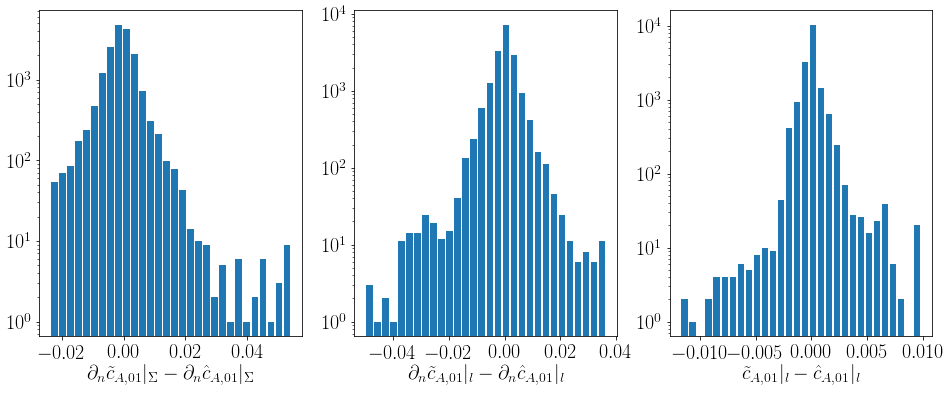

In [5]:
rc('text', usetex=True)
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 6))

text_labels = [r"$\partial_n \tilde{c}_{A,01}|_\Sigma-\partial_n \hat{c}_{A,01}|_\Sigma$",
               r"$\partial_n \tilde{c}_{A,01}|_l-\partial_n \hat{c}_{A,01}|_l$", 
               r"$\tilde{c}_{A,01}|_l-\hat{c}_{A,01}|_l$"]

for i, label in enumerate(phys_labels):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "phys_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_A.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    diff = y01 - y01_m
    axarr[i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
    axarr[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axarr[i].set_yscale("log")
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(text_labels[i], fontsize=hm.fontsize_tick)
savefig("phys_A_label_error_hist")

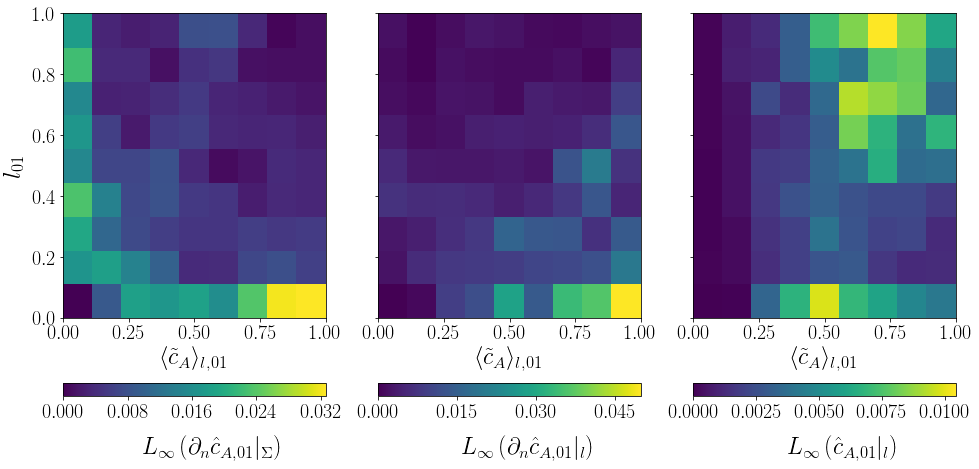

In [6]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 8), sharey=True)

text_labels = [r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_\Sigma\right)$",
               r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_l\right)$", 
               r"$L_\infty\left(\hat{c}_{A,01}|_l\right)$"]

for i, label in enumerate(phys_labels):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "phys_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_A.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    max_error = max_error_map(X01_A, y01, y01_m, 10)
    c = axarr[i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
    cbar = fig.colorbar(c, ax=axarr[i], orientation="horizontal", pad=0.15)
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.update_ticks()
    cbar.ax.set_ylabel(ylabel=text_labels[i], rotation=0, labelpad=-150, y=-5, fontsize=hm.fontsize_label)
    cbar.ax.tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(r"$\langle \tilde{c}_A \rangle_{l,01}$", fontsize=hm.fontsize_label)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
axarr[0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("phys_A_label_error_heat")

## Decay reaction

In [7]:
decay_labels_A = ["gradA_s", "gradA_f", "A_f"]
decay_labels_P = ["gradP_f", "P_f"]
data = data_files["decay"]
scaler_A = MinMaxScaler()
scaler_AP = MinMaxScaler()
X01_A = scaler_A.fit_transform(data[["dist", "A_av"]].values)
X01_AP = scaler_AP.fit_transform(data[["dist", "A_av", "P_av"]].values)

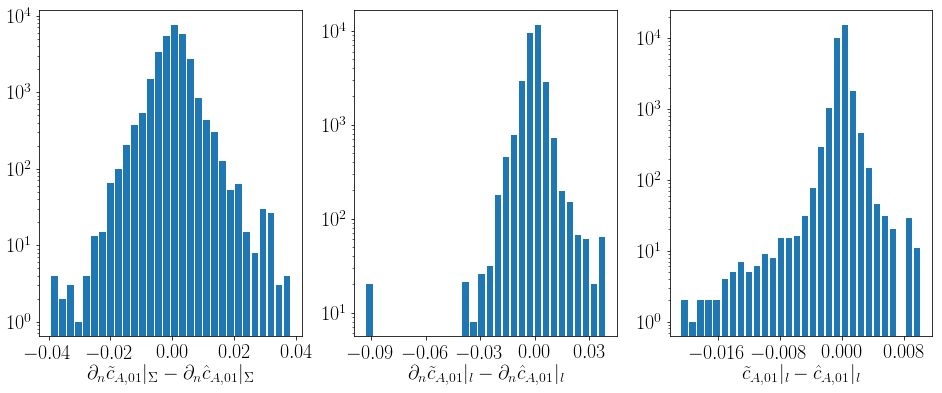

In [8]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 6))

text_labels = [r"$\partial_n \tilde{c}_{A,01}|_\Sigma-\partial_n \hat{c}_{A,01}|_\Sigma$",
                 r"$\partial_n \tilde{c}_{A,01}|_l-\partial_n \hat{c}_{A,01}|_l$", 
                 r"$\tilde{c}_{A,01}|_l-\hat{c}_{A,01}|_l$"]

for i, label in enumerate(decay_labels_A):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "decay_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_A.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    diff = y01 - y01_m
    axarr[i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
    axarr[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axarr[i].set_yscale("log")
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(text_labels[i], fontsize=hm.fontsize_tick)
savefig("decay_A_label_error_hist")

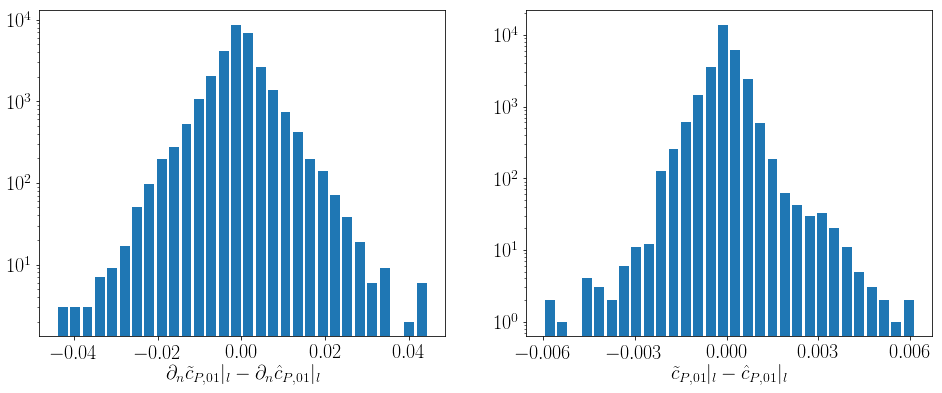

In [10]:
fig, axarr = plt.subplots(1, 2, figsize=(hm.figure_width, 6))

text_labels = [r"$\partial_n \tilde{c}_{P,01}|_l-\partial_n \hat{c}_{P,01}|_l$", 
               r"$\tilde{c}_{P,01}|_l-\hat{c}_{P,01}|_l$"]

for i, label in enumerate(decay_labels_P):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_AP.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "decay_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_AP.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    diff = y01 - y01_m
    axarr[i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
    axarr[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axarr[i].set_yscale("log")
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(text_labels[i], fontsize=hm.fontsize_tick)
savefig("decay_P_label_error_hist")

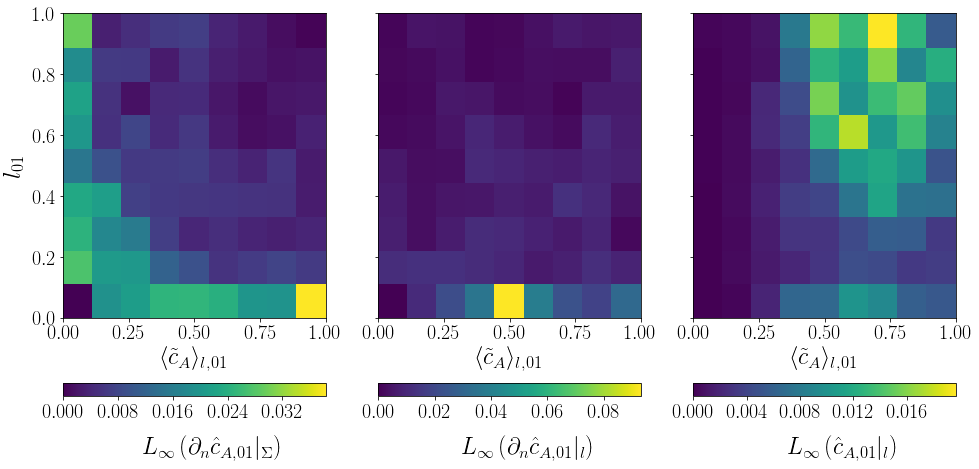

In [11]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 8), sharey=True)

text_labels = [r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_\Sigma\right)$",
               r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_l\right)$", 
               r"$L_\infty\left(\hat{c}_{A,01}|_l\right)$"]

for i, label in enumerate(decay_labels_A):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_A.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "decay_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_A.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    max_error = max_error_map(X01_A, y01, y01_m, 10)
    c = axarr[i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
    cbar = fig.colorbar(c, ax=axarr[i], orientation="horizontal", pad=0.15)
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.update_ticks()
    cbar.ax.set_ylabel(ylabel=text_labels[i], rotation=0, labelpad=-150, y=-5, fontsize=hm.fontsize_label)
    cbar.ax.tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(r"$\langle \tilde{c}_A \rangle_{l,01}$", fontsize=hm.fontsize_label)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
axarr[0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("decay_A_label_error_heat")

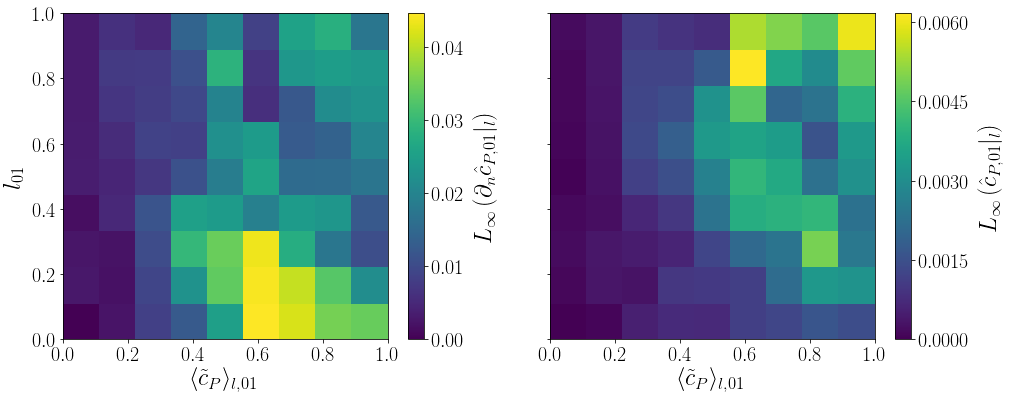

In [12]:
fig, axarr = plt.subplots(1, 2, figsize=(hm.figure_width, 6), sharey=True)

text_labels = [r"$L_\infty\left(\partial_n \hat{c}_{P,01}|_l\right)$", 
               r"$L_\infty\left(\hat{c}_{P,01}|_l\right)$"]

for i, label in enumerate(decay_labels_P):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_AP.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "decay_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_AP.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    max_error = max_error_map(X01_AP, y01, y01_m, 10)
    c = axarr[i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
    cbar = fig.colorbar(c, ax=axarr[i], orientation="vertical", pad=0.05)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.set_ylabel(ylabel=text_labels[i], rotation=90, labelpad=10, fontsize=hm.fontsize_label)
    cbar.ax.tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(r"$\langle \tilde{c}_P \rangle_{l,01}$", fontsize=hm.fontsize_label)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
axarr[0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("decay_P_label_error_heat")

## Single reaction

In [13]:
single_labels_A = ["gradA_s", "gradA_f", "A_f"]
single_labels_B = ["gradB_f", "B_f"]
single_labels_P = ["gradP_f", "P_f"]
data = data_files["single"]
scaler_AB = MinMaxScaler()
scaler_ABP = MinMaxScaler()
X01_AB = scaler_AB.fit_transform(data[["dist", "A_av", "B_av"]].values)
X01_ABP = scaler_ABP.fit_transform(data[["dist", "A_av", "B_av", "P_av"]].values)

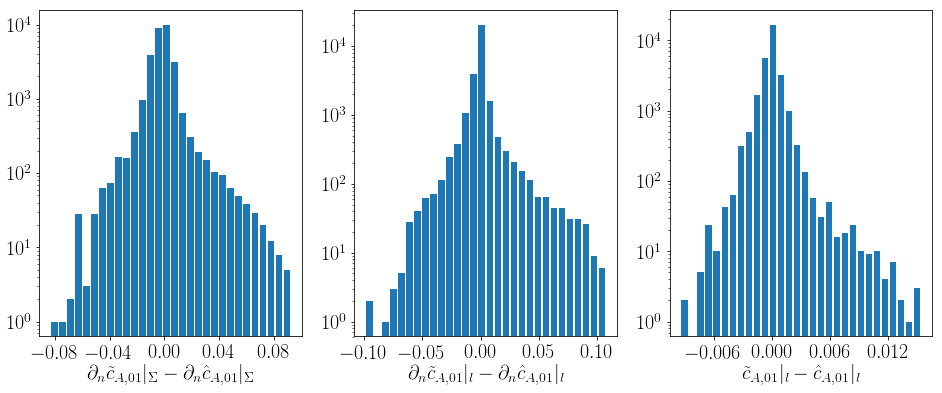

In [14]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 6))

text_labels = [r"$\partial_n \tilde{c}_{A,01}|_\Sigma-\partial_n \hat{c}_{A,01}|_\Sigma$",
                 r"$\partial_n \tilde{c}_{A,01}|_l-\partial_n \hat{c}_{A,01}|_l$", 
                 r"$\tilde{c}_{A,01}|_l-\hat{c}_{A,01}|_l$"]

for i, label in enumerate(single_labels_A):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_AB.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "single_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_AB.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    diff = y01 - y01_m
    axarr[i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
    axarr[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axarr[i].set_yscale("log")
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(text_labels[i], fontsize=hm.fontsize_tick)
savefig("single_A_label_error_hist")

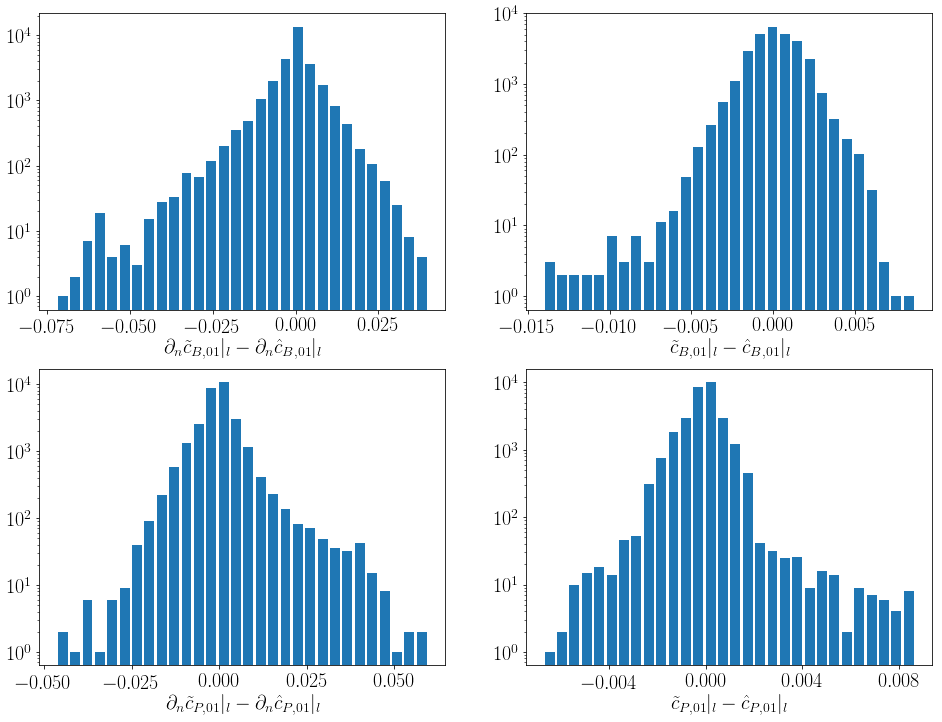

In [15]:
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 12))

text_labels = [
    r"$\partial_n \tilde{c}_{B,01}|_l-\partial_n \hat{c}_{B,01}|_l$", 
    r"$\tilde{c}_{B,01}|_l-\hat{c}_{B,01}|_l$",
    r"$\partial_n \tilde{c}_{P,01}|_l-\partial_n \hat{c}_{P,01}|_l$", 
    r"$\tilde{c}_{P,01}|_l-\hat{c}_{P,01}|_l$"
]

label_count = 0
for s, (X01_s, label_s) in enumerate(zip([X01_AB, X01_ABP], [single_labels_B, single_labels_P])):
    for i, label in enumerate(label_s):
        y = data[label].values
        y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
        model_dict["n_inputs"] = X01_s.shape[1]
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path_model + "single_" + label + ".pt"
        model.load_state_dict(torch.load(model_path))
        model.eval()
        X01_t = torch.from_numpy(X01_s.astype(np.float64))
        y01_m = model.forward(X01_t).detach().squeeze().numpy()
        diff = y01 - y01_m
        axarr[s, i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
        axarr[s, i].xaxis.set_major_locator(plt.MaxNLocator(5))
        axarr[s, i].set_yscale("log")
        axarr[s, i].tick_params(labelsize=hm.fontsize_tick)
        axarr[s, i].set_xlabel(text_labels[label_count], fontsize=hm.fontsize_tick)
        label_count += 1
savefig("single_BP_label_error_hist")

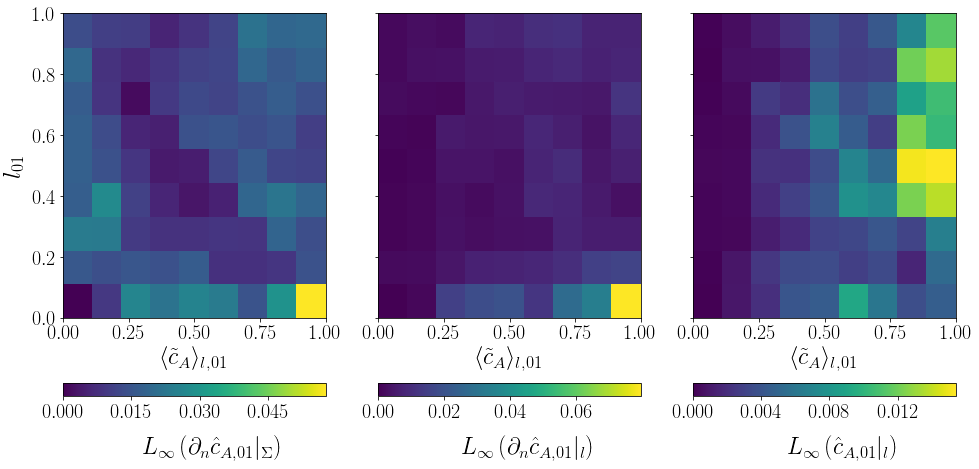

In [16]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 8), sharey=True)

text_labels = [r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_\Sigma\right)$",
               r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_l\right)$", 
               r"$L_\infty\left(\hat{c}_{A,01}|_l\right)$"]

for i, label in enumerate(single_labels_A):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_AB.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "single_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_AB.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    max_error = max_error_map(X01_AB, y01, y01_m, 10)
    c = axarr[i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
    cbar = fig.colorbar(c, ax=axarr[i], orientation="horizontal", pad=0.15)
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.update_ticks()
    cbar.ax.set_ylabel(ylabel=text_labels[i], rotation=0, labelpad=-150, y=-5, fontsize=hm.fontsize_label)
    cbar.ax.tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(r"$\langle \tilde{c}_A \rangle_{l,01}$", fontsize=hm.fontsize_label)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
axarr[0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("single_A_label_error_heat")

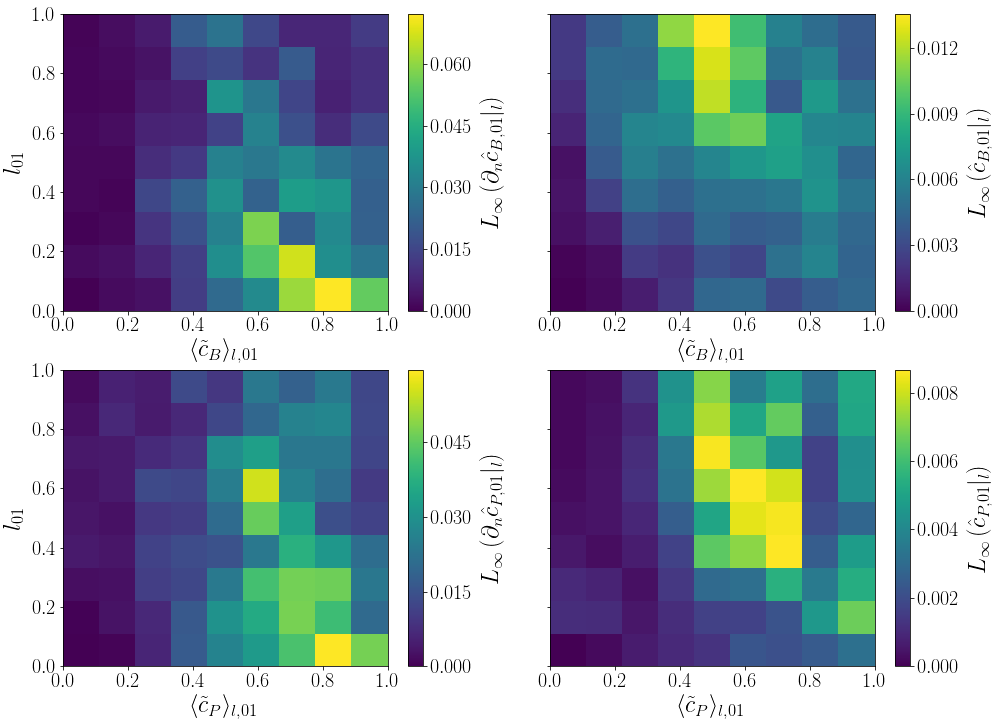

In [17]:
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 12), sharey=True)

text_labels = [
    r"$L_\infty\left(\partial_n \hat{c}_{B,01}|_l\right)$", 
    r"$L_\infty\left(\hat{c}_{B,01}|_l\right)$",
    r"$L_\infty\left(\partial_n \hat{c}_{P,01}|_l\right)$", 
    r"$L_\infty\left(\hat{c}_{P,01}|_l\right)$"
]
xs_labels = [
    r"$\langle \tilde{c}_B \rangle_{l,01}$",
    r"$\langle \tilde{c}_P \rangle_{l,01}$"
]

label_count = 0
for s, (X01_s, label_s) in enumerate(zip([X01_AB, X01_ABP], [single_labels_B, single_labels_P])):
    for i, label in enumerate(label_s):
        y = data[label].values
        y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
        model_dict["n_inputs"] = X01_s.shape[1]
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path_model + "single_" + label + ".pt"
        model.load_state_dict(torch.load(model_path))
        model.eval()
        X01_t = torch.from_numpy(X01_s.astype(np.float64))
        y01_m = model.forward(X01_t).detach().squeeze().numpy()
        max_error = max_error_map(X01_s, y01, y01_m, 10)
        c = axarr[s, i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
        cbar = fig.colorbar(c, ax=axarr[s, i], orientation="vertical", pad=0.05)
        cbar.locator = ticker.MaxNLocator(nbins=5)
        cbar.update_ticks()
        cbar.ax.set_ylabel(ylabel=text_labels[label_count], rotation=90, labelpad=10, fontsize=hm.fontsize_label)
        cbar.ax.tick_params(labelsize=hm.fontsize_tick)
        axarr[s, i].set_xlabel(xs_labels[s], fontsize=hm.fontsize_label)
        axarr[s, i].tick_params(labelsize=hm.fontsize_tick)
        label_count += 1
    axarr[s, 0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("single_BP_label_error_heat")

## Consecutive reaction

In [18]:
cons_labels_A = ["gradA_s", "gradA_f", "A_f"]
cons_labels_B = ["gradB_f", "B_f"]
cons_labels_P = ["gradP_f", "P_f"]
cons_labels_S = ["gradS_f", "S_f"]
data = data_files["cons"]
scaler_ABP = MinMaxScaler()
scaler_ABPS = MinMaxScaler()
X01_ABP = scaler_ABP.fit_transform(data[["dist", "A_av", "B_av", "P_av"]].values)
X01_ABPS = scaler_ABPS.fit_transform(data[["dist", "A_av", "B_av", "P_av", "S_av"]].values)

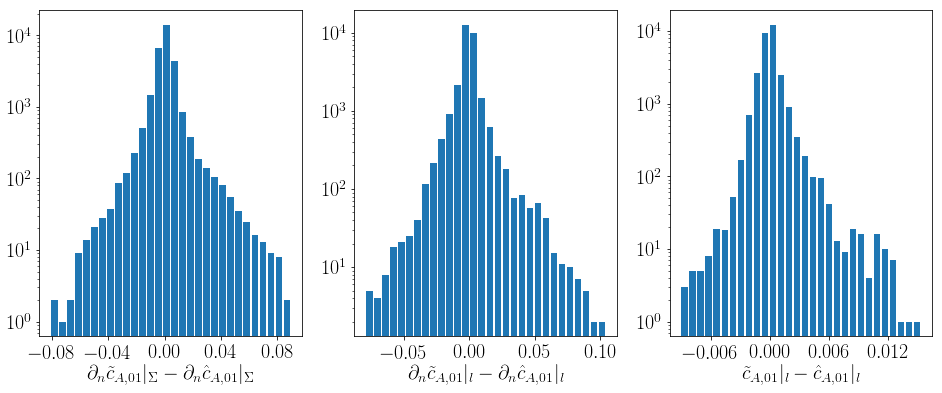

In [19]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 6))

text_labels = [r"$\partial_n \tilde{c}_{A,01}|_\Sigma-\partial_n \hat{c}_{A,01}|_\Sigma$",
               r"$\partial_n \tilde{c}_{A,01}|_l-\partial_n \hat{c}_{A,01}|_l$", 
               r"$\tilde{c}_{A,01}|_l-\hat{c}_{A,01}|_l$"]

for i, label in enumerate(cons_labels_A):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_ABP.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "cons_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_ABP.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    diff = y01 - y01_m
    axarr[i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
    axarr[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axarr[i].set_yscale("log")
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(text_labels[i], fontsize=hm.fontsize_tick)
savefig("cons_A_label_error_hist")

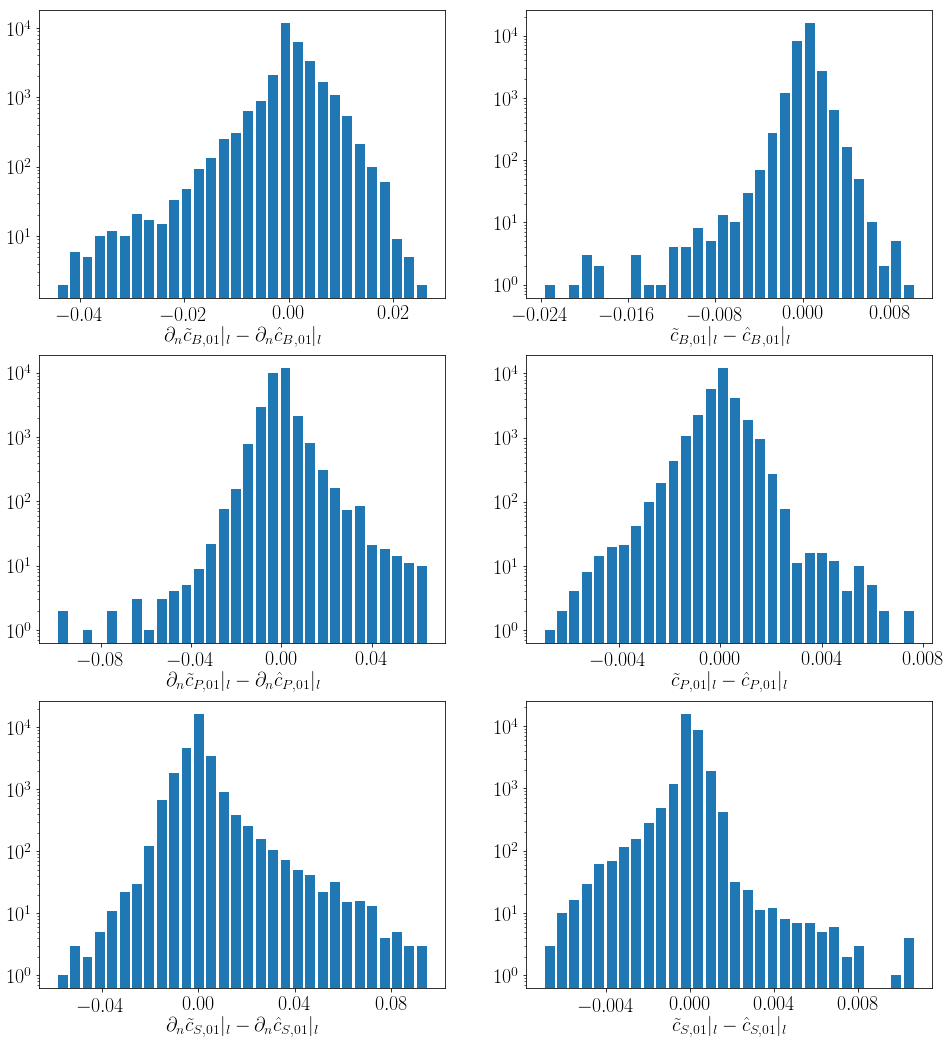

In [20]:
fig, axarr = plt.subplots(3, 2, figsize=(hm.figure_width, 18))

text_labels = [
    r"$\partial_n \tilde{c}_{B,01}|_l-\partial_n \hat{c}_{B,01}|_l$", 
    r"$\tilde{c}_{B,01}|_l-\hat{c}_{B,01}|_l$",
    r"$\partial_n \tilde{c}_{P,01}|_l-\partial_n \hat{c}_{P,01}|_l$", 
    r"$\tilde{c}_{P,01}|_l-\hat{c}_{P,01}|_l$",
    r"$\partial_n \tilde{c}_{S,01}|_l-\partial_n \hat{c}_{S,01}|_l$", 
    r"$\tilde{c}_{S,01}|_l-\hat{c}_{S,01}|_l$"
]

label_count = 0
for s, (X01_s, label_s) in enumerate(zip([X01_ABP, X01_ABP, X01_ABPS], [cons_labels_B, cons_labels_P, cons_labels_S])):
    for i, label in enumerate(label_s):
        y = data[label].values
        y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
        model_dict["n_inputs"] = X01_s.shape[1]
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path_model + "cons_" + label + ".pt"
        model.load_state_dict(torch.load(model_path))
        model.eval()
        X01_t = torch.from_numpy(X01_s.astype(np.float64))
        y01_m = model.forward(X01_t).detach().squeeze().numpy()
        diff = y01 - y01_m
        axarr[s, i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
        axarr[s, i].xaxis.set_major_locator(plt.MaxNLocator(5))
        axarr[s, i].set_yscale("log")
        axarr[s, i].tick_params(labelsize=hm.fontsize_tick)
        axarr[s, i].set_xlabel(text_labels[label_count], fontsize=hm.fontsize_tick)
        label_count += 1
savefig("cons_BPS_label_error_hist")

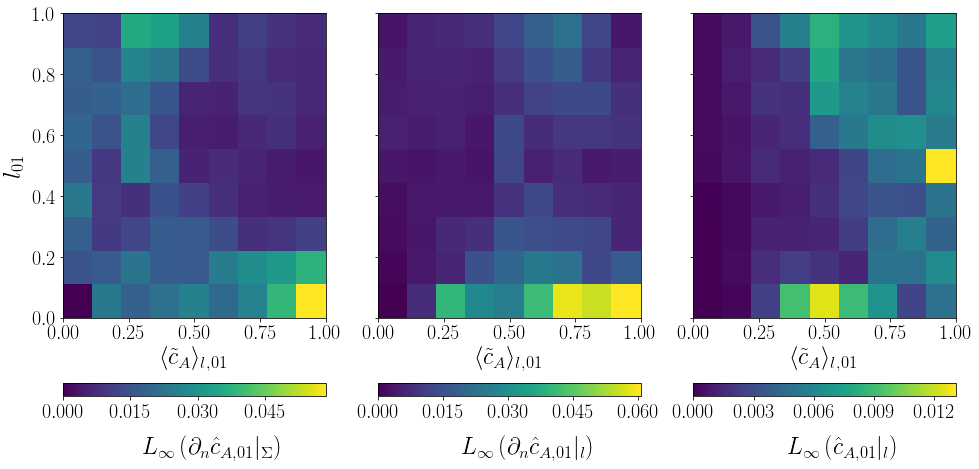

In [21]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 8), sharey=True)

text_labels = [r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_\Sigma\right)$",
               r"$L_\infty\left(\partial_n \hat{c}_{A,01}|_l\right)$", 
               r"$L_\infty\left(\hat{c}_{A,01}|_l\right)$"]

for i, label in enumerate(cons_labels_A):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_ABP.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "cons_" + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_ABP.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    max_error = max_error_map(X01_ABP, y01, y01_m, 10)
    c = axarr[i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
    cbar = fig.colorbar(c, ax=axarr[i], orientation="horizontal", pad=0.15)
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.update_ticks()
    cbar.ax.set_ylabel(ylabel=text_labels[i], rotation=0, labelpad=-150, y=-5, fontsize=hm.fontsize_label)
    cbar.ax.tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(r"$\langle \tilde{c}_A \rangle_{l,01}$", fontsize=hm.fontsize_label)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
axarr[0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("cons_A_label_error_heat")

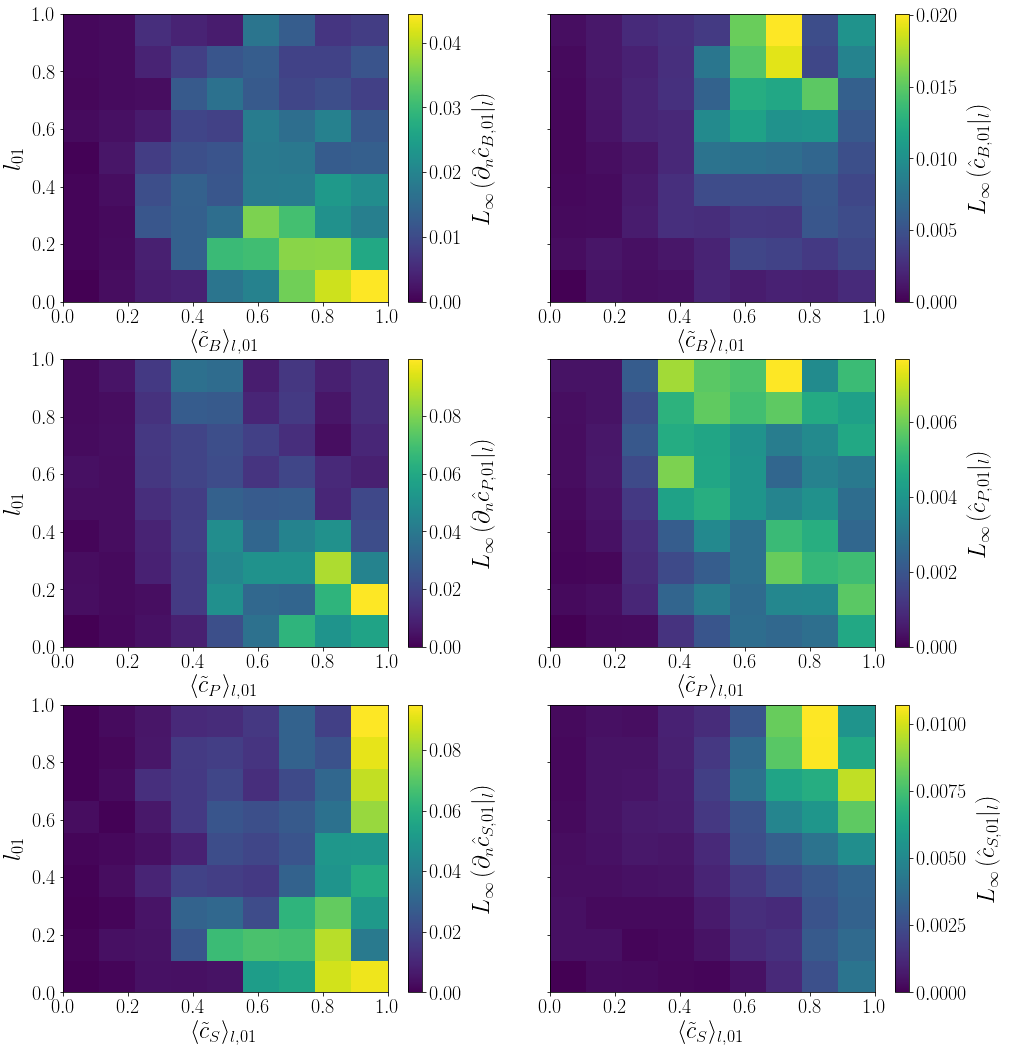

In [22]:
fig, axarr = plt.subplots(3, 2, figsize=(hm.figure_width, 18), sharey=True)

text_labels = [
    r"$L_\infty\left(\partial_n \hat{c}_{B,01}|_l\right)$", 
    r"$L_\infty\left(\hat{c}_{B,01}|_l\right)$",
    r"$L_\infty\left(\partial_n \hat{c}_{P,01}|_l\right)$", 
    r"$L_\infty\left(\hat{c}_{P,01}|_l\right)$",
    r"$L_\infty\left(\partial_n \hat{c}_{S,01}|_l\right)$", 
    r"$L_\infty\left(\hat{c}_{S,01}|_l\right)$"
]
xs_labels = [
    r"$\langle \tilde{c}_B \rangle_{l,01}$",
    r"$\langle \tilde{c}_P \rangle_{l,01}$",
    r"$\langle \tilde{c}_S \rangle_{l,01}$"
]

label_count = 0
for s, (X01_s, label_s) in enumerate(zip([X01_ABP, X01_ABP, X01_ABPS], [cons_labels_B, cons_labels_P, cons_labels_S])):
    for i, label in enumerate(label_s):
        y = data[label].values
        y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
        model_dict["n_inputs"] = X01_s.shape[1]
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path_model + "cons_" + label + ".pt"
        model.load_state_dict(torch.load(model_path))
        model.eval()
        X01_t = torch.from_numpy(X01_s.astype(np.float64))
        y01_m = model.forward(X01_t).detach().squeeze().numpy()
        max_error = max_error_map(X01_s, y01, y01_m, 10)
        c = axarr[s, i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
        cbar = fig.colorbar(c, ax=axarr[s, i], orientation="vertical", pad=0.05)
        cbar.locator = ticker.MaxNLocator(nbins=5)
        cbar.update_ticks()
        cbar.ax.set_ylabel(ylabel=text_labels[label_count], rotation=90, labelpad=10, fontsize=hm.fontsize_label)
        cbar.ax.tick_params(labelsize=hm.fontsize_tick)
        axarr[s, i].set_xlabel(xs_labels[s], fontsize=hm.fontsize_label)
        axarr[s, i].tick_params(labelsize=hm.fontsize_tick)
        label_count += 1
    axarr[s, 0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("cons_BPS_label_error_heat")

## Source terms

In [23]:
source_labels = ["rAB_av", "rAB_av", "rAP_av"]
data_s = data_files["single"]
data_c = data_files["cons"]
scaler_AB_s = MinMaxScaler()
scaler_AB_c = MinMaxScaler()
scaler_AP_c = MinMaxScaler()
X01_AB_s = scaler_AB_s.fit_transform(data_s[["dist", "A_av", "B_av"]].values)
X01_AB_c = scaler_AB_c.fit_transform(data_c[["dist", "A_av", "B_av"]].values)
X01_AP_c = scaler_AP_c.fit_transform(data_c[["dist", "A_av", "P_av"]].values)

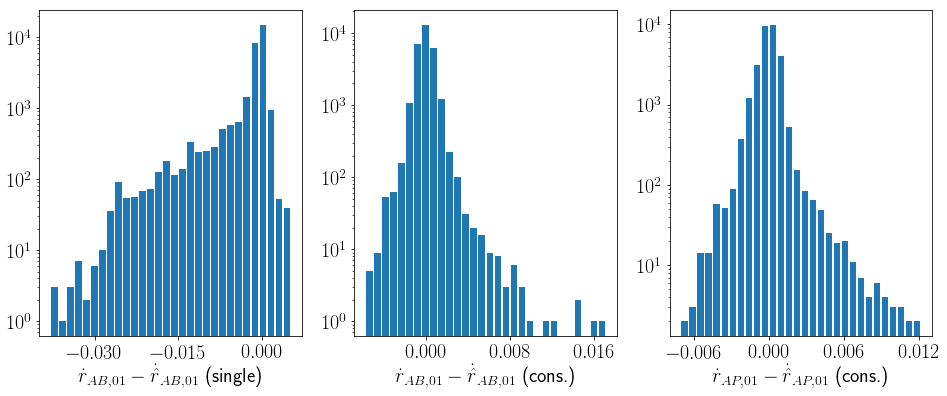

In [24]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 6))

text_labels = [r"$\dot{r}_{AB,01}-\dot{\hat{r}}_{AB,01}$ (single)",
               r"$\dot{r}_{AB,01}-\dot{\hat{r}}_{AB,01}$ (cons.)", 
               r"$\dot{r}_{AP,01}-\dot{\hat{r}}_{AP,01}$ (cons.)"]

ml_model_pre = ["single_", "cons_", "cons_"]

for i, (X01_s, label) in enumerate(zip([X01_AB_s, X01_AB_c, X01_AP_c], source_labels)):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_s.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + ml_model_pre[i] + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_s.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    diff = y01 - y01_m
    axarr[i].hist(diff, 30, density=False, facecolor='C0', alpha=1, rwidth=0.8, align="mid")
    axarr[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axarr[i].set_yscale("log")
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(text_labels[i], fontsize=hm.fontsize_tick)
savefig("source_error_hist")

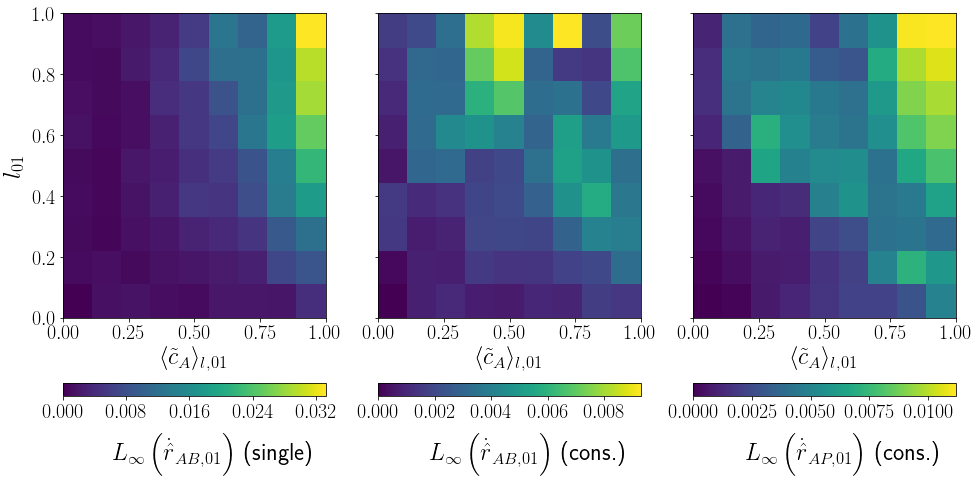

In [25]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 8), sharey=True)

text_labels = [r"$L_\infty\left(\dot{\hat{r}}_{AB,01}\right)$ (single)",
               r"$L_\infty\left(\dot{\hat{r}}_{AB,01}\right)$ (cons.)", 
               r"$L_\infty\left(\dot{\hat{r}}_{AP,01}\right)$ (cons.)"]

ml_model_pre = ["single_", "cons_", "cons_"]

for i, (X01_s, label) in enumerate(zip([X01_AB_s, X01_AB_c, X01_AP_c], source_labels)):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model_dict["n_inputs"] = X01_s.shape[1]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + ml_model_pre[i] + label + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    X01_t = torch.from_numpy(X01_s.astype(np.float64))
    y01_m = model.forward(X01_t).detach().squeeze().numpy()
    max_error = max_error_map(X01_s, y01, y01_m, 10)
    c = axarr[i].pcolormesh(xx, yy, max_error.T, cmap="viridis")
    cbar = fig.colorbar(c, ax=axarr[i], orientation="horizontal", pad=0.15)
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.update_ticks()
    cbar.ax.set_ylabel(ylabel=text_labels[i], rotation=0, labelpad=-150, y=-6, fontsize=hm.fontsize_label)
    cbar.ax.tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlabel(r"$\langle \tilde{c}_A \rangle_{l,01}$", fontsize=hm.fontsize_label)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
axarr[0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
savefig("source_error_heat")